In [53]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import time

# ОБРАБОТКА ДАННЫХ

In [58]:
def merge_chunks_full_tracks(zip_path, max_interaction_chunks=20):
    with ZipFile(zip_path, 'r') as zip_file:
        tracks_stream = zip_file.open('zvuk-track_artist_embedding.parquet')
        df_tracks_full = pq.read_pandas(tracks_stream).to_pandas()
        print(f"Полная tracks таблица: {df_tracks_full.shape}")

    # Фильтруем tracks
    df_tracks = df_tracks_full[['track_id', 'artist_id', 'cluster_id']].drop_duplicates()

    # 2. читаем interactions ПО чанкам и сразу сливаем с tracks
    all_merged_chunks = []

    with ZipFile(zip_path, 'r') as zip_file:
        interactions_file = pq.ParquetFile(zip_file.open('zvuk-interactions.parquet'))
        print(f"Всего row groups: {interactions_file.num_row_groups}")

        for i in range(min(max_interaction_chunks, interactions_file.num_row_groups)):
            # Читаем чанк
            chunk = interactions_file.read_row_group(i).to_pandas()

            # Берем только нужные колонки
            chunk_txn = chunk[['user_id', 'track_id', 'session_id', 'datetime', 'play_duration']]

            merged_chunk = chunk_txn.merge(
                df_tracks,
                on='track_id',
                how='left'
            )

            all_merged_chunks.append(merged_chunk)
            print(f"Чанк {i+1}: {chunk.shape[0]} → {merged_chunk.shape[0]} строк")

    # 3. Собираем все чанки
    df_merged_full = pd.concat(all_merged_chunks, ignore_index=True)

    # 4. dropna только в конце на итоговом наборе
    before_dropna = len(df_merged_full)
    df_clean = df_merged_full.dropna(subset=['artist_id', 'cluster_id'])
    print(f"\nПосле dropna: {before_dropna:,} → {len(df_clean):,} строк ({100*(1-len(df_clean)/before_dropna):.1f}% удалено)")

    return df_clean

df_merged = merge_chunks_full_tracks('data/archive.zip', max_interaction_chunks=50)  # 50+ чанков = почти все данные
print(f"Финальный размер: {df_merged.shape}")


Полная tracks таблица: (2199876, 4)
Всего row groups: 933
Чанк 1: 262243 → 371024 строк
Чанк 2: 262243 → 372075 строк
Чанк 3: 262243 → 369357 строк
Чанк 4: 262243 → 370706 строк
Чанк 5: 262243 → 369224 строк
Чанк 6: 262243 → 371542 строк
Чанк 7: 262243 → 370001 строк
Чанк 8: 262243 → 369124 строк
Чанк 9: 262243 → 372090 строк
Чанк 10: 262243 → 371558 строк
Чанк 11: 262243 → 373336 строк
Чанк 12: 262243 → 370313 строк
Чанк 13: 262243 → 371585 строк
Чанк 14: 262243 → 371341 строк
Чанк 15: 262243 → 369705 строк
Чанк 16: 262243 → 373468 строк
Чанк 17: 262243 → 369405 строк
Чанк 18: 262243 → 370396 строк
Чанк 19: 262243 → 371476 строк
Чанк 20: 262243 → 372044 строк
Чанк 21: 262243 → 370684 строк
Чанк 22: 262243 → 371682 строк
Чанк 23: 262243 → 370939 строк
Чанк 24: 262243 → 370163 строк
Чанк 25: 262243 → 370188 строк
Чанк 26: 262243 → 370050 строк
Чанк 27: 262243 → 369625 строк
Чанк 28: 262243 → 370537 строк
Чанк 29: 262243 → 369343 строк
Чанк 30: 262243 → 369635 строк
Чанк 31: 262243 → 371

In [59]:
# Очистка датасета: только ключевые колонки
key_columns = ['user_id', 'track_id', 'artist_id', 'cluster_id']
df_merged = df_merged[key_columns]

print("\nИНФОРМАЦИЯ О ДАТАСЕТЕ:")
print(f"Размер:                 {df_merged.shape[0]:,} строк × {df_merged.shape[1]} колонок")
print(f"Пользователей:          {df_merged['user_id'].nunique():,}")
print(f"Уникальных треков:      {df_merged['track_id'].nunique():,}")
print(f"Артистов:               {df_merged['artist_id'].nunique():,}")
print(f"Кластеров:              {df_merged['cluster_id'].nunique():,}")
print(f"Среднее треков/польз.:  {df_merged.groupby('user_id')['track_id'].nunique().mean():.1f}")
print(f"Топ-5 кластеров:\n{df_merged['cluster_id'].value_counts().head().to_string()}")

print(f"\nСтруктура:")
print(df_merged.head())
print(f"\nТипы данных:")
print(df_merged.dtypes)



ИНФОРМАЦИЯ О ДАТАСЕТЕ:
Размер:                 18,542,805 строк × 4 колонок
Пользователей:          171,930
Уникальных треков:      574,682
Артистов:               121,157
Кластеров:              128
Среднее треков/польз.:  43.1
Топ-5 кластеров:
cluster_id
42     1929815
127    1068343
93     1035756
113     864185
40      751486

Структура:
   user_id  track_id  artist_id  cluster_id
0  1938823   1242546     105645         113
1  1938823    145031      36195           6
2  1938823    145031     201493           6
3  1938823    145031      36195           6
4  1938823    145031     201493           6

Типы данных:
user_id       int32
track_id      int32
artist_id     int32
cluster_id    int32
dtype: object


Статистика уникальных треков по пользователям:
count    171930.000000
mean         43.089856
std          59.265114
min           1.000000
25%           8.000000
50%          23.000000
75%          55.000000
max        1729.000000
Name: track_id, dtype: float64


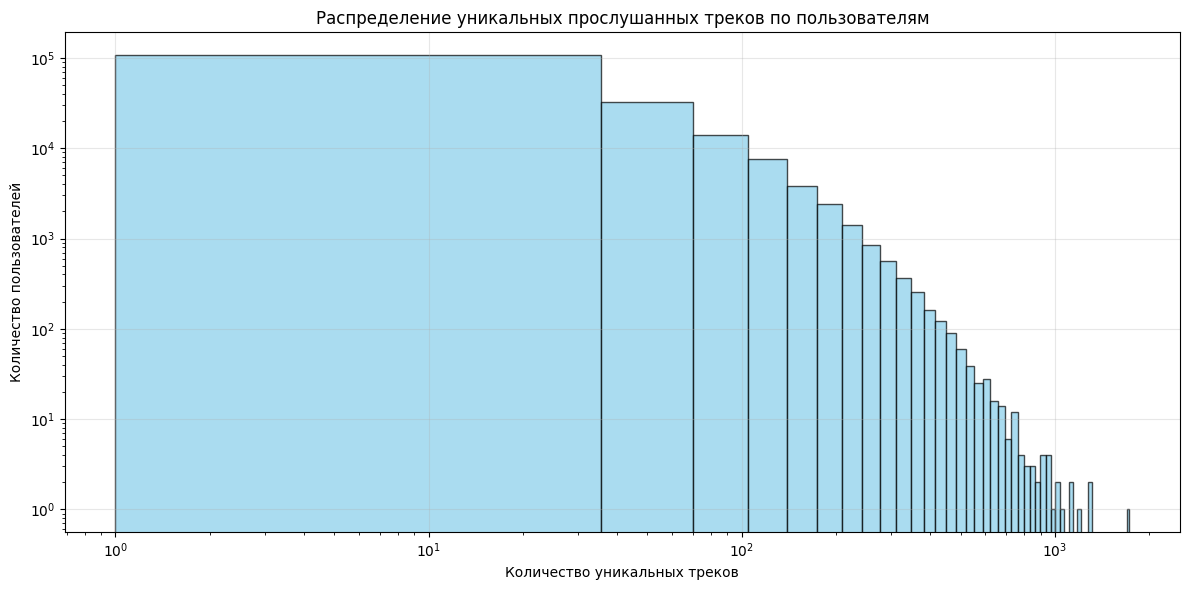

In [60]:
unique_tracks_per_user = df_merged.groupby('user_id')['track_id'].nunique()

print("Статистика уникальных треков по пользователям:")
print(unique_tracks_per_user.describe())

# Гистограмма с логарифмическими данными
plt.figure(figsize=(12, 6))
plt.hist(unique_tracks_per_user, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
plt.xlabel('Количество уникальных треков')
plt.ylabel('Количество пользователей')
plt.title('Распределение уникальных прослушанных треков по пользователям')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# APRIORI

In [61]:
# 1. Создаем бинарную матрицу пользователей x кластеры
user_cluster_matrix = df_merged.pivot_table(
    index='user_id',
    columns='cluster_id',
    aggfunc='size',
    fill_value=0
) > 0

print(f"Матрица user x cluster: {user_cluster_matrix.shape}")
print(f"Пользователей: {user_cluster_matrix.shape[0]:,}")
print(f"Кластеров: {user_cluster_matrix.shape[1]}")

start_time = time.time()

# 2. Находим частые наборы кластеров
frequent_clusters = apriori(
    user_cluster_matrix,
    min_support=0.03,
    max_len=5,
    use_colnames=True,
    low_memory=True
)

# 3. Генерируем все правила ассоциаций
rules = association_rules(frequent_clusters,
                          metric="lift",
                          min_threshold=1.0) # lift >= 1.0

apriori_time = time.time() - start_time
print(f"Apriori: {len(frequent_clusters):,} наборов, {len(rules):,} правил")
print(f"Время: {apriori_time:.1f} сек")


print(f"\nНайдено правил ассоциаций: {len(rules):,}")
print("\nМетрики:")
print("support - доля пользователей со ВСЕМИ кластерами правила")
print("confidence - вероятность B при A")
print("lift - во сколько раз чаще B при A (чем случайно)")
print("leverage - разница support(A∪B) от независимости")

# 4. вывод правил с метриками
print("\nнайденные правила ассоциаций (кластер A → кластер B)")
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift', 'leverage']].round(4))

# 5. Топ-10 лучших правил
print("\nтоп-10 правил по lift (самые сильные ассоциации):")
top_rules = rules.nlargest(10, 'lift')[['antecedents', 'consequents', 'support', 'confidence', 'lift', 'leverage']]
print(top_rules.round(4))

# 6. Статистика правил
print(f"\nСтатистика по правилам:")
print(f"Средний lift: {rules['lift'].mean():.3f}")
print(f"Максимальный lift: {rules['lift'].max():.3f}")
print(f"Правил с lift > 1.5: {len(rules[rules['lift'] > 1.5]):,}")
print(f"Правил с confidence > 0.3: {len(rules[rules['confidence'] > 0.3]):,}")


Матрица user x cluster: (171930, 128)
Пользователей: 171,930
Кластеров: 128
Apriori: 219,717 наборов, 5,201,398 правил
Время: 248.5 сек

Найдено правил ассоциаций: 5,201,398

Метрики:
support - доля пользователей со ВСЕМИ кластерами правила
confidence - вероятность B при A
lift - во сколько раз чаще B при A (чем случайно)
leverage - разница support(A∪B) от независимости

найденные правила ассоциаций (кластер A → кластер B)
              antecedents                      consequents  support  \
0          frozenset({1})                   frozenset({3})   0.0423   
1          frozenset({3})                   frozenset({1})   0.0423   
2          frozenset({1})                   frozenset({4})   0.0756   
3          frozenset({4})                   frozenset({1})   0.0756   
4          frozenset({1})                   frozenset({5})   0.1352   
...                   ...                              ...      ...   
5201393  frozenset({107})  frozenset({120, 113, 124, 127})   0.0525   
52013

КЛАСТЕРИЗАЦИЯ
Матрица признаков: (171930, 20)

Характеристики кластеров:
        user_id total_clusters      
          count           mean   std
cluster                             
0        146822           13.0  10.8
1          7459           33.7  17.1
2          9666           29.4  14.4
3          4448           22.4  14.6
4          3535           27.8  15.4


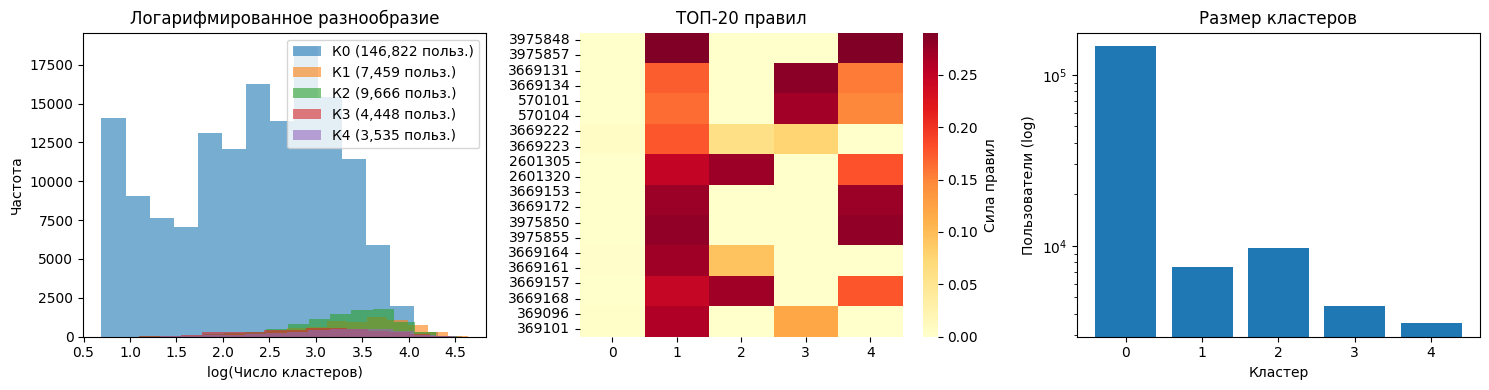


Профили кластеров:
К0 (146,822 польз.): 121 → 69 (lift=8.60)
К1 (7,459 польз.): 25 → 73 (lift=8.88)
К2 (9,666 польз.): 125 → 73 (lift=8.58)
К3 (4,448 польз.): 123 → 25 (lift=8.77)
К4 (3,535 польз.): 25 → 73 (lift=8.88)


In [62]:
print("КЛАСТЕРИЗАЦИЯ")

# 1. Создаем признаки из топ-20 правил
top_rules_idx = rules.nlargest(20, 'lift').index
user_rules_simple = pd.DataFrame(
    0.0,
    index=user_cluster_matrix.index,
    columns=top_rules_idx,
    dtype=float
)

# Заполняем матрицу
for rule_idx in top_rules_idx:
    rule = rules.loc[rule_idx]
    antecedent = list(rule['antecedents'])[0]
    consequent = list(rule['consequents'])[0]

    has_both = user_cluster_matrix[antecedent] & user_cluster_matrix[consequent]
    strength = float(rule['lift'] * rule['support'])
    user_rules_simple.loc[has_both, rule_idx] = strength

print(f"Матрица признаков: {user_rules_simple.shape}")

# 2. KMeans кластеризация
user_features = user_rules_simple.fillna(0)
scaler = StandardScaler()
user_features_scaled = scaler.fit_transform(user_features)

kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
user_clusters = kmeans.fit_predict(user_features_scaled)

# 3. Статистика кластеров
cluster_summary = pd.DataFrame({
    'cluster': user_clusters,
    'user_id': user_cluster_matrix.index,
    'total_clusters': user_cluster_matrix.sum(axis=1)
})

cluster_stats = cluster_summary.groupby('cluster').agg({
    'user_id': 'count',
    'total_clusters': ['mean', 'std']
}).round(1)

print("\nХарактеристики кластеров:")
print(cluster_stats)

# 4. Визуализация
plt.figure(figsize=(15, 4))

# логарифмированный график
plt.subplot(1, 3, 1)
for i in range(5):
    data = cluster_summary[cluster_summary['cluster'] == i]['total_clusters']
    plt.hist(np.log1p(data), alpha=0.6, label=f'К{i} ({len(data):,} польз.)', bins=15)  # log1p для безопасности

plt.xlabel('log(Число кластеров)')
plt.ylabel('Частота')
plt.legend()
plt.title('Логарифмированное разнообразие')

# Тепловая карта
plt.subplot(1, 3, 2)
cluster_means = user_rules_simple.groupby(user_clusters).mean()
sns.heatmap(cluster_means.T, cmap='YlOrRd', cbar_kws={'label': 'Сила правил'})
plt.title('ТОП-20 правил')

# Размеры кластеров (логарифмическая Y)
plt.subplot(1, 3, 3)
cluster_sizes = pd.Series(user_clusters).value_counts().sort_index()
plt.bar(cluster_sizes.index, cluster_sizes.values)
plt.yscale('log')  # Логарифм по Y
plt.xlabel('Кластер')
plt.ylabel('Пользователи (log)')
plt.title('Размер кластеров')

plt.tight_layout()
plt.show()


# 5. Профили кластеров
print("\nПрофили кластеров:")
for i in range(5):
    cluster_size = np.sum(user_clusters == i)
    top_strength = user_rules_simple.iloc[user_clusters == i].sum().nlargest(1)
    if len(top_strength) > 0:
        rule_idx = top_strength.index[0]
        ant = list(rules.loc[rule_idx, 'antecedents'])[0]
        cons = list(rules.loc[rule_idx, 'consequents'])[0]
        print(f"К{i} ({cluster_size:,} польз.): {ant} → {cons} (lift={rules.loc[rule_idx, 'lift']:.2f})")



# FP-growth

In [63]:
user_cluster_matrix = df_merged.pivot_table(
    index='user_id', columns='cluster_id', aggfunc='size', fill_value=0
) > 0

print(f"Матрица: {user_cluster_matrix.shape}")

# ⏱Замеряем время
start_time = time.time()

frequent_clusters_fp = fpgrowth(
    user_cluster_matrix,
    min_support=0.03,
    max_len=5,
    use_colnames=True
)

rules_fp = association_rules(
    frequent_clusters_fp,
    metric="lift",
    min_threshold=1.0
)

fp_time = time.time() - start_time
print(f"FP-Growth: {len(frequent_clusters_fp):,} наборов, {len(rules_fp):,} правил")
print(f"Время: {fp_time:.1f} сек")

print("\nтоп-10 правил FP-Growth:")
print(rules_fp.nlargest(10, 'lift')[['antecedents', 'consequents', 'lift']].round(4))

print(f"\nСравнение:")
print(f"Apriori правил: {len(rules):,}")
print(f"FP-Growth правил: {len(rules_fp):,} {len(rules_fp)/len(rules)*100:.0f}%")


Матрица: (171930, 128)
FP-Growth: 219,717 наборов, 5,201,398 правил
Время: 164.8 сек

топ-10 правил FP-Growth:
                       antecedents                consequents    lift
4119106  frozenset({25, 125, 101})        frozenset({73, 69})  8.8787
4119115        frozenset({73, 69})  frozenset({25, 125, 101})  8.8787
4455685  frozenset({123, 125, 23})        frozenset({25, 27})  8.7681
4455700        frozenset({25, 27})  frozenset({123, 125, 23})  8.7681
4151672        frozenset({25, 95})       frozenset({123, 23})  8.6461
4151673       frozenset({123, 23})        frozenset({25, 95})  8.6461
4117232  frozenset({121, 125, 25})        frozenset({69, 23})  8.5986
4117233        frozenset({69, 23})  frozenset({121, 125, 25})  8.5986
1941291  frozenset({125, 69, 101})        frozenset({73, 12})  8.5772
1941306        frozenset({73, 12})  frozenset({125, 69, 101})  8.5772

Сравнение:
Apriori правил: 5,201,398
FP-Growth правил: 5,201,398 100%


In [64]:
# Сравнение топ-5 правил
print("Сравнение топ-5 найденных правил по lift:")
print("\nAPRIORI:")
print(rules.nlargest(5, 'lift')[['antecedents', 'consequents', 'lift']].round(4))

print("\nFP-GROWTH:")
print(rules_fp.nlargest(5, 'lift')[['antecedents', 'consequents', 'lift']].round(4))


Сравнение топ-5 найденных правил по lift:

APRIORI:
                       antecedents                consequents    lift
3975848  frozenset({25, 125, 101})        frozenset({73, 69})  8.8787
3975857        frozenset({73, 69})  frozenset({25, 125, 101})  8.8787
3669131  frozenset({123, 125, 23})        frozenset({25, 27})  8.7681
3669134        frozenset({25, 27})  frozenset({123, 125, 23})  8.7681
570101         frozenset({25, 95})       frozenset({123, 23})  8.6461

FP-GROWTH:
                       antecedents                consequents    lift
4119106  frozenset({25, 125, 101})        frozenset({73, 69})  8.8787
4119115        frozenset({73, 69})  frozenset({25, 125, 101})  8.8787
4455685  frozenset({123, 125, 23})        frozenset({25, 27})  8.7681
4455700        frozenset({25, 27})  frozenset({123, 125, 23})  8.7681
4151672        frozenset({25, 95})       frozenset({123, 23})  8.6461


КЛАСТЕРИЗАЦИЯ
Матрица признаков: (171930, 20)

ХАРАКТЕРИСТИКИ КЛАСТЕРОВ:
        user_id total_clusters      
          count           mean   std
cluster                             
0        146822           13.0  10.8
1          7459           33.7  17.1
2          9666           29.4  14.4
3          4448           22.4  14.6
4          3535           27.8  15.4


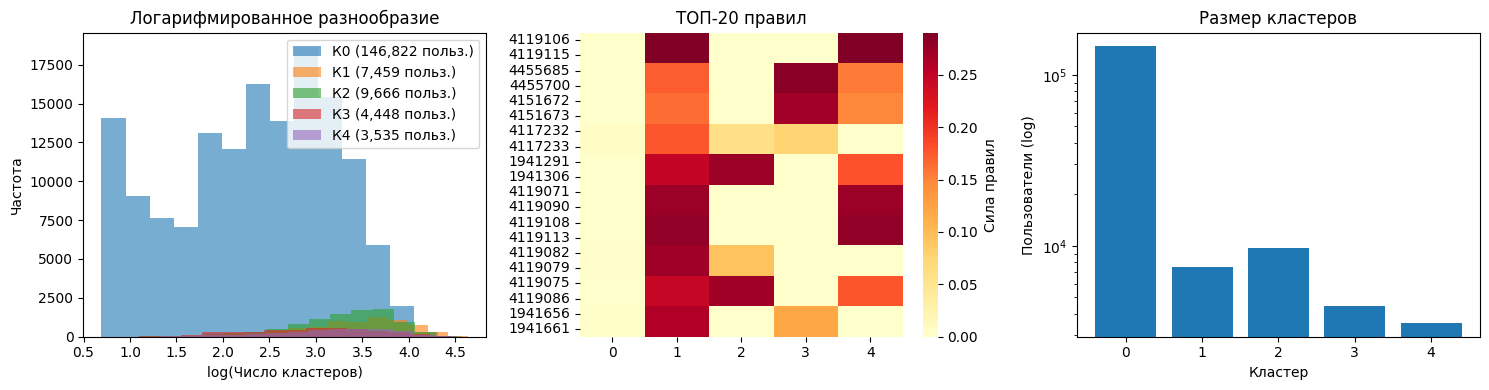


ПРОФИЛИ КЛАСТЕРОВ:
К0 (146,822 польз.): 121 → 69 (lift=8.60)
К1 (7,459 польз.): 25 → 73 (lift=8.88)
К2 (9,666 польз.): 125 → 73 (lift=8.58)
К3 (4,448 польз.): 123 → 25 (lift=8.77)
К4 (3,535 польз.): 25 → 73 (lift=8.88)


In [65]:
print("КЛАСТЕРИЗАЦИЯ")

# 1. Создаем признаки из ТОП-20 правил
top_rules_idx = rules_fp.nlargest(20, 'lift').index
user_rules_simple = pd.DataFrame(
    0.0,
    index=user_cluster_matrix.index,
    columns=top_rules_idx,
    dtype=float
)

# Заполняем матрицу
for rule_idx in top_rules_idx:
    rule = rules_fp.loc[rule_idx]
    antecedent = list(rule['antecedents'])[0]
    consequent = list(rule['consequents'])[0]

    has_both = user_cluster_matrix[antecedent] & user_cluster_matrix[consequent]
    strength = float(rule['lift'] * rule['support'])
    user_rules_simple.loc[has_both, rule_idx] = strength

print(f"Матрица признаков: {user_rules_simple.shape}")

# 2. KMeans кластеризация
user_features = user_rules_simple.fillna(0)
scaler = StandardScaler()
user_features_scaled = scaler.fit_transform(user_features)

kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
user_clusters = kmeans.fit_predict(user_features_scaled)

# 3. Статистика кластеров
cluster_summary = pd.DataFrame({
    'cluster': user_clusters,
    'user_id': user_cluster_matrix.index,
    'total_clusters': user_cluster_matrix.sum(axis=1)
})

cluster_stats = cluster_summary.groupby('cluster').agg({
    'user_id': 'count',
    'total_clusters': ['mean', 'std']
}).round(1)

print("\nХАРАКТЕРИСТИКИ КЛАСТЕРОВ:")
print(cluster_stats)

# 4. Визуализация
plt.figure(figsize=(15, 4))

# логарифмированный график
plt.subplot(1, 3, 1)
for i in range(5):
    data = cluster_summary[cluster_summary['cluster'] == i]['total_clusters']
    plt.hist(np.log1p(data), alpha=0.6, label=f'К{i} ({len(data):,} польз.)', bins=15)  # log1p для безопасности

plt.xlabel('log(Число кластеров)')
plt.ylabel('Частота')
plt.legend()
plt.title('Логарифмированное разнообразие')

# Тепловая карта
plt.subplot(1, 3, 2)
cluster_means = user_rules_simple.groupby(user_clusters).mean()
sns.heatmap(cluster_means.T, cmap='YlOrRd', cbar_kws={'label': 'Сила правил'})
plt.title('ТОП-20 правил')

# Размеры кластеров (логарифмическая Y)
plt.subplot(1, 3, 3)
cluster_sizes = pd.Series(user_clusters).value_counts().sort_index()
plt.bar(cluster_sizes.index, cluster_sizes.values)
plt.yscale('log')  # Логарифм по Y
plt.xlabel('Кластер')
plt.ylabel('Пользователи (log)')
plt.title('Размер кластеров')

plt.tight_layout()
plt.show()


# 5. Профили кластеров
print("\nПРОФИЛИ КЛАСТЕРОВ:")
for i in range(5):
    cluster_size = np.sum(user_clusters == i)
    top_strength = user_rules_simple.iloc[user_clusters == i].sum().nlargest(1)
    if len(top_strength) > 0:
        rule_idx = top_strength.index[0]
        ant = list(rules_fp.loc[rule_idx, 'antecedents'])[0]
        cons = list(rules_fp.loc[rule_idx, 'consequents'])[0]
        print(f"К{i} ({cluster_size:,} польз.): {ant} → {cons} (lift={rules_fp.loc[rule_idx, 'lift']:.2f})")

